import library yang dibutuhkan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objects
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
import datetime
from keras.callbacks import ReduceLROnPlateau

import file data

In [5]:
# prompt: import csv file from google drive

from google.colab import drive
drive.mount('/content/drive')

# Replace 'your_file_path' with the actual path to your CSV file in Google Drive
file_path = '/content/drive/MyDrive/MSFT_2006-01-01_to_2018-01-01.csv'

df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
1,2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT
2,2006-01-05,26.96,27.13,26.91,26.99,48247610,MSFT
3,2006-01-06,26.89,27.00,26.49,26.91,100969092,MSFT
4,2006-01-09,26.93,27.07,26.76,26.86,55627836,MSFT


kita hanya membutuhkan tanggal dan harga saat close saja

In [6]:
df.drop(['Open', 'High', 'Low', 'Volume', 'Name'], axis=1, inplace=True)

check duplicate, null values dan data type

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Close   3019 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.3+ KB


In [9]:
df.isna().sum()

,0
Date,0
Close,0


In [10]:
df.duplicated().sum()

0

In [12]:
df.set_index('Date', inplace=True)

visualisasi dengan line chart

In [13]:
max_price = df['Close'].max()
max_price_date = df['Close'].idxmax()

# Membuat figure Plotly
fig = go.Figure()

# Menambahkan garis df
fig.add_trace(go.Scatter(
    x=df.index, y=df['Close'],
    mode='lines+markers',
    name='Close Price History',
    line=dict(color='blue'),
    marker=dict(symbol='circle')
))

# Menambahkan anotasi untuk harga tertinggi
fig.add_trace(go.Scatter(
    x=[max_price_date], y=[max_price],
    mode='markers+text',
    text=[f'{max_price:.2f}'],
    textposition='top center',
    marker=dict(color='red', size=10),
    name='Max Price'
))

# Menambahkan garis horizontal pada harga tertinggi
fig.add_shape(
    type='line',
    x0=df.index.min(), x1=df.index.max(),
    y0=max_price, y1=max_price,
    line=dict(color='red', dash='dash'),
    name='Max Price Line'
)

# Menyesuaikan layout
fig.update_layout(
    title='Close Price History',
    xaxis_title='Date',
    yaxis_title='Close Price',
    xaxis=dict(
        tickformat='%b %Y',
        showgrid=True
    ),
    yaxis=dict(
        showgrid=True,
        type='log'
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

# Menampilkan plot
fig.show()

melakukan preprocessing sebelum masuk ke deep learning

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']].values.reshape(-1, 1))
scaled_data

array([[0.16304045],
       [0.16485356],
       [0.1651325 ],
       ...,
       [0.98410042],
       [0.98423989],
       [0.98172943]])

In [15]:
def buat_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(x), np.array(y)

In [16]:
seq_length = 30

train = scaled_data[:int(len(scaled_data) * 0.8)]
test = scaled_data[int(len(scaled_data) * 0.8):]

X_train, y_train = buat_sequences(train, seq_length)
X_test, y_test = buat_sequences(test, seq_length)

In [17]:
#Layer pertama
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

#layer kedua
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

#layer ketiga
model.add(Dense(units=25))

#layer keempat
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [18]:
# Menggunakan Adam optimizer dan MSE loss function
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
# Melatih model
history = model.fit(X_train, y_train, epochs=70, batch_size=84, validation_data=(X_test, y_test))

Epoch 1/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.0213 - val_loss: 0.0115
Epoch 2/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 6.5451e-04 - val_loss: 0.0011
Epoch 4/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 5.7904e-04 - val_loss: 4.6609e-04
Epoch 5/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 5.1923e-04 - val_loss: 4.2934e-04
Epoch 6/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 4.9854e-04 - val_loss: 4.1871e-04
Epoch 7/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 4.8174e-04 - val_loss: 5.0565e-04
Epoch 8/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 4.1795e-04 - val_loss: 4.7171e-04
Epoch 9/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 4.0915e-04 - val_loss: 7.8151e-04
Epoch 10/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 3.7176e-04 - val_loss: 4.2049e-04
Epoch 11/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 3.8415e-04 - val_loss: 5.167

In [20]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
Mean Squared Error: 1.12
R-squared: 0.99


In [21]:
last_30_days = df['Close'].values[-seq_length:]
last_30_days_scaled = scaler.transform(last_30_days.reshape(-1, 1))

X_prediksi = []
X_prediksi.append(last_30_days)

X_prediksi = np.array(X_prediksi)
X_prediksi = np.reshape(X_prediksi, (X_prediksi.shape[0], X_prediksi.shape[1], 1))

prediksi = model.predict(X_prediksi)
prediksi = scaler.inverse_transform(prediksi)

print(f'Harga prediksi untuk hari ini: {prediksi[0][0]:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Harga prediksi untuk hari ini: 343.77


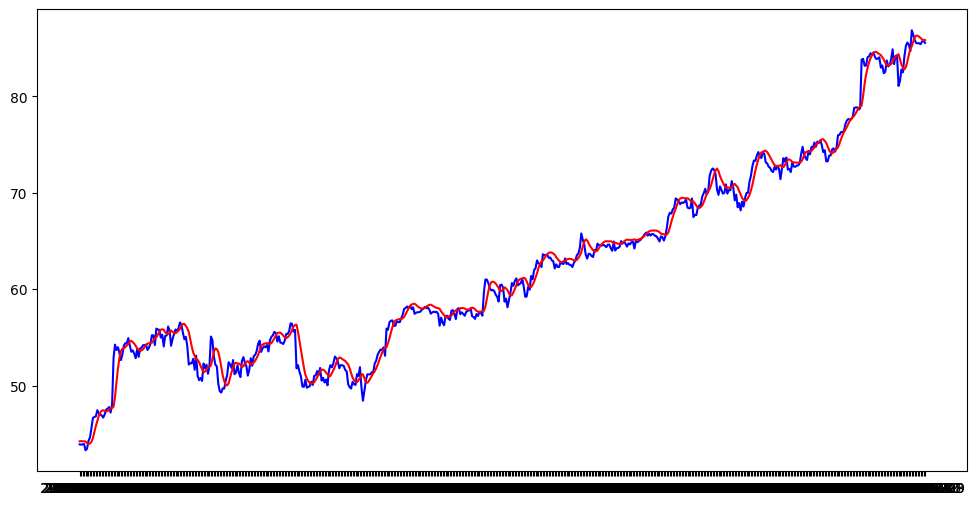

In [22]:
plt.figure(figsize=(12, 6))

plt.plot(df.index[-len(y_test):], y_test_scaled, label='Aktual', color='blue')
plt.plot(df.index[-len(predictions):], predictions, label='Prediksi', color='red')

plt.show()

In [33]:
future_days = 60

last_60_days = df['Close'].values[-seq_length:]
last_60_days_scaled = scaler.transform(last_60_days.reshape(-1, 1))
future_predictions = []

for i in range(future_days):
    X_prediksi = []
    X_prediksi.append(last_60_days_scaled)
    X_prediksi = np.array(X_prediksi)
    X_prediksi = np.reshape(X_prediksi, (X_prediksi.shape[0], X_prediksi.shape[1], 1))

    harga_prediksi = model.predict(X_prediksi)
    harga_prediksi_unscaled = scaler.inverse_transform(harga_prediksi)

    future_predictions.append(harga_prediksi_unscaled[0][0])

    new_scaled_data = np.append(last_60_days_scaled[1:], harga_prediksi, axis=0)
    last_60_days_scaled = new_scaled_data.reshape(-1, 1)

future_dates = pd.date_range(start=df.index[-1], periods=future_days+1, freq='D')[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

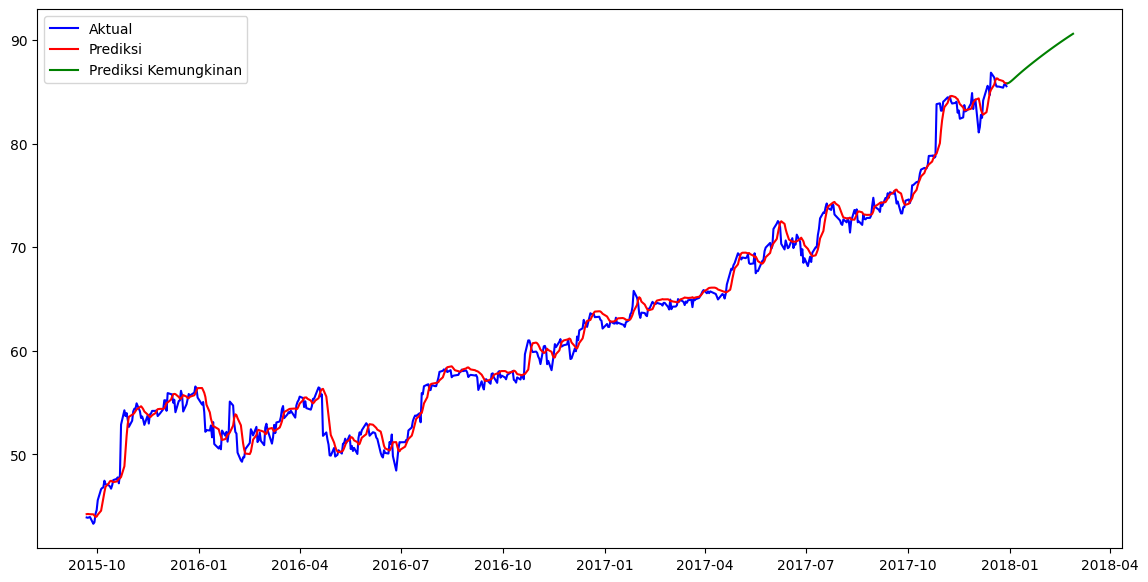

In [34]:
import matplotlib.pyplot as plt


df.index = pd.to_datetime(df.index)

plt.figure(figsize=(14,7))

# Menampilkan data aktual
plt.plot(df.index[-len(y_test_scaled):], y_test_scaled, label='Aktual', color='blue')

# Menampilkan data prediksi
plt.plot(df.index[-len(y_test_scaled):], predictions, label='Prediksi', color='red')

# Menampilkan prediksi masa depan
plt.plot(future_dates.to_pydatetime(), future_predictions, label='Prediksi Kemungkinan', color='green')

plt.legend()
plt.show()
